In [19]:
!pip install -q -U kaggle_environments
!pip install -q -U pydash

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

from random import randrange

 

# пишем агенты
#0 - rock
#1 - paper
#2 - scissors

Код ниже создает функции на основе всех комбинаций камень-ножницы-бумага.  Чтобы соответсвовать минимуму дз по колличеству агентов - я выбрала сделать по 4 варианта (например (0,0,0,0), (0,0,0,1) и т.д) Функции получают различный набор возможных вариантов хода, а затем с помощью random выдают return. Всего 16 комбинаций


In [21]:
from itertools import combinations_with_replacement 

# генерируем различные комбинации
l = [0,1,2]
comb = combinations_with_replacement(l, 4) 
  

# создаем назване будущих функций в соответсвии с комбинациями
counter = 0
names = {}

for combination in comb: 
    print(combination)
    
    var = ''
    for number in combination:
        if number == 0:
          var += 'rock_'
        elif number == 1:
          var += 'paper_'
        else:
          var += 'scissors_'

    names[var] = combination
    counter += 1



(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 2, 2)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 2, 2)
(0, 2, 2, 2)
(1, 1, 1, 1)
(1, 1, 1, 2)
(1, 1, 2, 2)
(1, 2, 2, 2)
(2, 2, 2, 2)


In [22]:
# генерируем файлы с функциями с использованием раннее созданных имен
# Функции выбирают рандомное значение из комбинации. Так как все комбинации разнае 
# у каждой функции разная вероятность выбрать камень или ножницы или бумагу


name_list = []
for i in names:
  name = i+'.py'
  name_list.append(name)
  f = open(name, "w")
  f.write('from random import randrange \n')
  f.write('names ='+str(names)+'\n')
  f.write(f"def {i}(observation, configuration): \n    values = names['{str(i)}'] \n    number  = randrange(0,4) \n    \
return values[number]")

  f.close()



Далее я добавляю еще функции из сети для разнообразия.

In [23]:
%%writefile stats_base_agent.py

import random
import pydash
from collections import Counter

# нужна какая-то история для функционирования этого агента
history = {
    "guess":      [0,1,2],
    "prediction": [0,1,2],
    "expected":   [0,1,2],
    "action":     [1,2,0],
    "opponent":   [0,1],
    "rotn":       [0,1],
}

def statistical_prediction_agent(observation, configuration):    
    global history
    actions          = list(range(configuration.signs))   
    last_action      = history['action'][-1]
    prev_opp_action  = history['opponent'][-1]
    opponent_action  = observation.lastOpponentAction if observation.step > 0 else 2
    rotn             = (opponent_action - prev_opp_action) % configuration.signs

    history['opponent'].append(opponent_action)
    history['rotn'].append(rotn)
    
    move_frequency   = Counter(history['rotn'])
    action_frequency = Counter(zip(history['action'], history['rotn'])) 
    move_weights     = [   move_frequency.get(n, 1) 
                         + action_frequency.get((last_action,n), 1) 
                         for n in range(configuration.signs) ] 
    guess            = random.choices( population=actions, weights=move_weights, k=1 )[0]
    
    guess_frequency  = Counter(zip(history['guess'], history['rotn']))
    guess_weights    = [ guess_frequency.get((guess,n), 1) 
                         for n in range(configuration.signs) ]
    prediction       = random.choices( population=actions, weights=guess_weights, k=1 )[0]

    pred_frequency   = Counter(zip(history['prediction'], history['rotn']))
    pred_weights     = [ pred_frequency.get((prediction,n), 1) 
                         for n in range(configuration.signs) ]
    expected         = random.choices( population=actions, weights=pred_weights, k=1 )[0]

    
    pure_random_chance = observation.step / (configuration.episodeSteps * 2)
    if random.random() < pure_random_chance:
        action = random.randint(0, configuration.signs-1)
        is_pure_random_chance = True
    else:
        # Play the +1 counter move
        # action = (expected + 1) % configuration.signs                  # without rotn
        action = (opponent_action + expected + 1) % configuration.signs  # using   rotn
        is_pure_random_chance = False
    
    # Persist state
    history['guess'].append(guess)
    history['prediction'].append(prediction)
    history['expected'].append(expected)
    history['action'].append(action)

    # Print debug information
    print('step                      = ', observation.step)
    print('opponent_action           = ', opponent_action)
    print('guess,      move_weights  = ', guess,      move_weights)
    print('prediction, guess_weights = ', prediction, guess_weights)
    print('expected,   pred_weights  = ', expected,   pred_weights)
    print('action                    = ', action)
    print('pure_random_chance        = ', f'{100*pure_random_chance:.2f}%', is_pure_random_chance)
    print()
    
    return action

Overwriting stats_base_agent.py


In [24]:
%%writefile markov_agent.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting markov_agent.py


готовим список для автоматизированого запуска соревнований. сгенерированные функции уже там, я добавляю две других 

In [25]:
name_list.append('markov_agent.py')
name_list.append('stats_base_agent.py')
name_list

['rock_rock_rock_rock_.py',
 'rock_rock_rock_paper_.py',
 'rock_rock_rock_scissors_.py',
 'rock_rock_paper_paper_.py',
 'rock_rock_paper_scissors_.py',
 'rock_rock_scissors_scissors_.py',
 'rock_paper_paper_paper_.py',
 'rock_paper_paper_scissors_.py',
 'rock_paper_scissors_scissors_.py',
 'rock_scissors_scissors_scissors_.py',
 'paper_paper_paper_paper_.py',
 'paper_paper_paper_scissors_.py',
 'paper_paper_scissors_scissors_.py',
 'paper_scissors_scissors_scissors_.py',
 'scissors_scissors_scissors_scissors_.py',
 'markov_agent.py',
 'stats_base_agent.py']

Создаем пустышку для сохранения очков

In [26]:
n_agents = len(name_list)

scores = np.zeros((n_agents, n_agents), dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Через цикл запускаем сравнение и сохраняем очки

In [28]:
print("Начало проверки ботов")

for ind_agent_1 in range(len(name_list)):
     
    for ind_agent_2 in range(ind_agent_1 + 1, len(name_list)):
         
        #print("LOG:",name_list[ind_agent_1]," vs ",name_list[ind_agent_2])
        
        current_score = evaluate(
            "rps", 
            [name_list[ind_agent_1], name_list[ind_agent_2]], 
            configuration={"episodeSteps": 350}
        )
        
        scores[ind_agent_1, ind_agent_2] = current_score[0][0]
        scores[ind_agent_2, ind_agent_1] = current_score[0][1]
      
    
 

Начало проверки ботов


Трансформируем все в dataframe и визуализируем

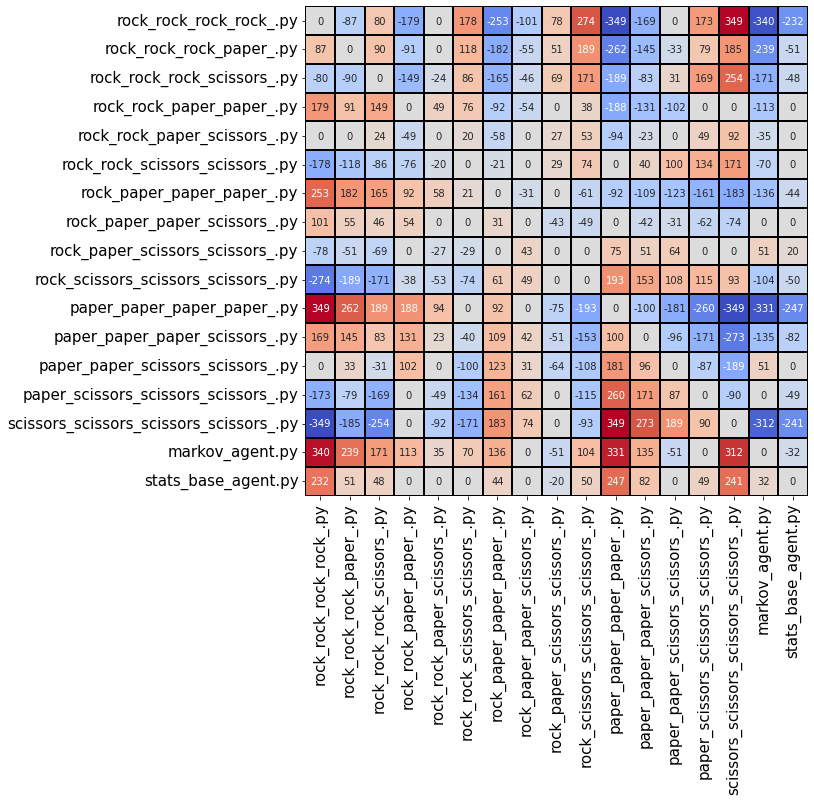

In [29]:
df_scores = pd.DataFrame(
    scores, 
    index=name_list, 
    columns=name_list,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, 
    cmap='coolwarm', linewidths=1, 
    linecolor='black', fmt="d",
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15);

Отдельно считаем среднее значение, так как визуально не совсем понятно, какая стратегия - оптимальная

In [30]:
df_scores['mean'] = df_scores.mean(axis=0)

df_scores['mean']

rock_rock_rock_rock_.py                     34.000000
rock_rock_rock_paper_.py                    15.235294
rock_rock_rock_scissors_.py                 15.588235
rock_rock_paper_paper_.py                    5.764706
rock_rock_paper_scissors_.py                -0.352941
rock_rock_scissors_scissors_.py              1.235294
rock_paper_paper_paper_.py                   9.941176
rock_paper_paper_scissors_.py                0.823529
rock_paper_scissors_scissors_.py            -2.941176
rock_scissors_scissors_scissors_.py         10.647059
paper_paper_paper_paper_.py                 33.058824
paper_paper_paper_scissors_.py              11.705882
paper_paper_scissors_scissors_.py           -2.235294
paper_scissors_scissors_scissors_.py         6.882353
scissors_scissors_scissors_scissors_.py     31.705882
markov_agent.py                           -108.941176
stats_base_agent.py                        -62.117647
Name: mean, dtype: float64

# Выводы
- Внезапно, но лучше всего себя показали стретегии однозначного выбора. только камень или только бумага или только ножницы
- при этом более "умные" стратегии как раз хорошо работают против такого однозначного выбора, но теряются при случайном выборе